# Basic machine learning pipeline

In [2]:

# import packages

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

from sklearn.model_selection import GridSearchCV

In [3]:
#| label: importdata
# Import data
df = pd.read_csv("./data/UV_pilot.csv")

# Split features and target
X = df.loc[:,"4000":"403"]
y = df.loc[:,"Exposed"]

# Split into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, test_size=0.2)

In [4]:
#| label: modellist
model_dict = {
    "LR": LogisticRegression(),
    "SVM": SVC(),
    "RF": RandomForestClassifier(),
}

In [5]:
#| label: modelcomparison
results = []
names = []
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=7)

for key, model in model_dict.items():
    pipe = Pipeline([('scaler', StandardScaler()), ('model', model)])

    cv_results = cross_val_score(pipe, X_train, y_train, cv=sss, scoring="accuracy")
    results.append(cv_results)
    names.append(key)
    print(f'Accuracy using {key} is {cv_results.mean():.2f} ± {cv_results.std():.2f}')



Accuracy using LR is 0.87 ± 0.07
Accuracy using SVM is 0.72 ± 0.08
Accuracy using RF is 0.74 ± 0.07


[Text(1, 0, 'LR'), Text(2, 0, 'SVM'), Text(3, 0, 'RF')]

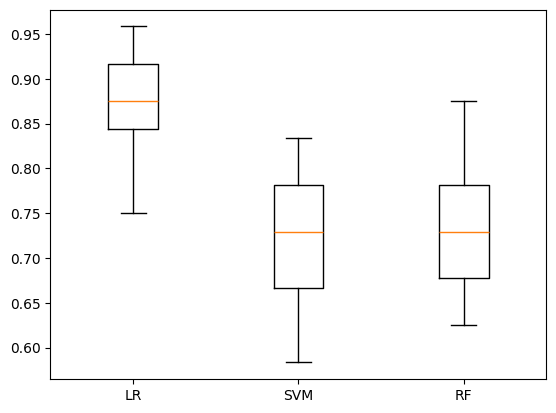

In [6]:
#| label: modelcomparisonplot
fig, ax = plt.subplots()
ax.boxplot(results)
ax.set_xticklabels(names)


In [7]:
#| label: parameters
# create a dictionary with different hyperparameters and the values you want to test

param_grid = {'model__penalty': ['l1', 'l2'],
                  'model__C': [0.01, 0.1, 1, 10],
                  'model__solver': ['liblinear', 'saga']}

# create the new pipleine with the model we choose to optimize
pipe = Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(max_iter=10000))])


In [8]:
#| label: optimization
search = GridSearchCV(pipe, param_grid, n_jobs=2)
search.fit(X_train, y_train)
print(f"Best parameter (CV score={search.best_score_:.2f})")
print(search.best_params_)

Best parameter (CV score=0.91)
{'model__C': 1, 'model__penalty': 'l1', 'model__solver': 'saga'}


In [9]:
#| label: bestestimator
search.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=1, max_iter=10000, penalty='l1',
                                    solver='saga'))])

In [10]:
#| label: prediction
optimized_model = search.best_estimator_
optimized_model.fit(X_train, y_train)
y_pred = optimized_model.predict(X_test)

In [19]:
y_pred

array(['NOU', 'NOU', 'YES', 'YES', 'YES', 'YES', 'NOU', 'YES', 'YES',
       'NOU', 'NOU', 'NOU', 'YES', 'YES', 'YES', 'NOU', 'NOU', 'YES',
       'YES', 'NOU'], dtype=object)

Text(0.5, 1.0, 'Accuracy of final model = 0.950')

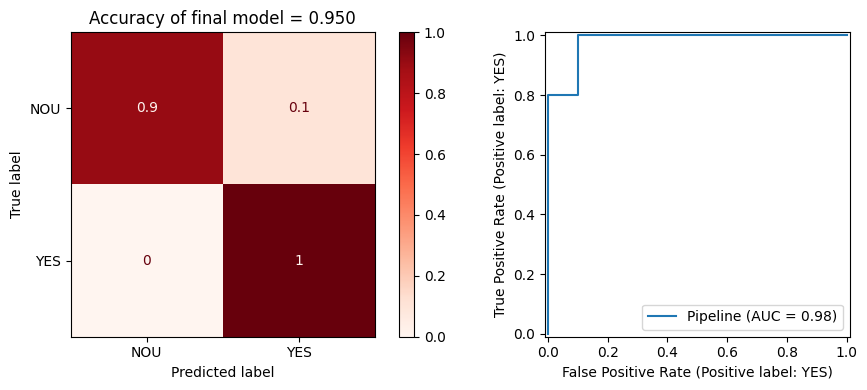

In [24]:
#| label: metrics
# Accuracy and confusion  matrix

fig, (ax, ax2) = plt.subplots(1,2, figsize=(10,4), tight_layout=True)


ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', cmap='Reds',ax=ax)

RocCurveDisplay.from_estimator(optimized_model, X_test, y_test, ax=ax2)


title1 = (f'Accuracy of final model = {accuracy_score(y_test, y_pred):.3f}')
ax.set_title(title1)


## Feature importance

In [70]:
#| label: importdatalessfeature
# Import data
df = pd.read_csv("./data/UV_pilot.csv")

wavenumbers = ['3856', '3401', '3275', '2923', '2859', '1902', '1745', '1636', '1538', '1457', '1307', '1153', '1076', '1027', '881', '527', '401']


# Split features and target
X = df[wavenumbers]
y = df.loc[:,"Exposed"]

# Split into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, test_size=0.2)

In [71]:
# create a dictionary with different hyperparameters and the values you want to test

param_grid = {'model__penalty': ['l1', 'l2'],
                  'model__C': [0.01, 0.1, 1, 10],
                  'model__solver': ['liblinear', 'saga']}

# create the new pipleine with the model we choose to optimize
pipe = Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(max_iter=10000))])

In [72]:
search = GridSearchCV(pipe, param_grid, n_jobs=2)
search.fit(X_train, y_train)
print(f"Best parameter (CV score={search.best_score_:.2f})")
print(search.best_params_)

Best parameter (CV score=0.70)
{'model__C': 1, 'model__penalty': 'l1', 'model__solver': 'saga'}


In [73]:
#| label: optimal
optimized_model = search.best_estimator_
optimized_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=1, max_iter=10000, penalty='l1',
                                    solver='saga'))])

In [74]:
#| label: coeff
# accessing the model coefficients
optimized_model.named_steps['model'].coef_

array([[-0.73180761, -1.13038731,  0.        ,  0.        ,  0.        ,
         0.        , -0.02957209,  0.        ,  0.        ,  0.        ,
         0.01832993, -1.26561288,  1.76822707,  0.        ,  0.        ,
         0.        ,  0.        ]])

In [75]:
#| label: featuredf
feature_importance = pd.DataFrame()
feature_importance['Wavenumbers'] = wavenumbers
feature_importance['Coefficients'] = optimized_model.named_steps['model'].coef_.T
feature_importance['Wavenumbers'] = feature_importance['Wavenumbers'].astype('category')
feature_importance

,Wavenumbers,Coefficients
0,3856,-0.731808
1,3401,-1.130387
2,3275,0.000000
3,2923,0.000000
4,2859,0.000000
5,1902,0.000000
6,1745,-0.029572
7,1636,0.000000
8,1538,0.000000
9,1457,0.000000


<Axes: ylabel='Wavenumbers'>

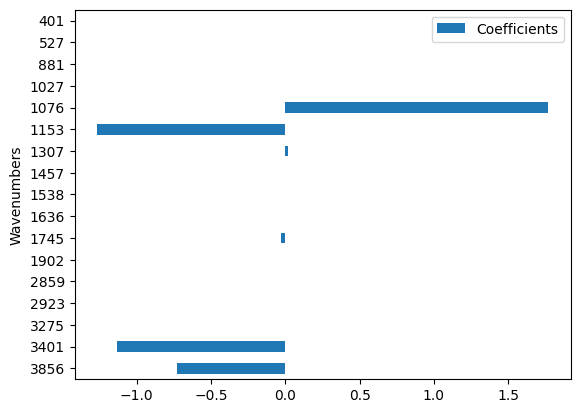

In [76]:
#| label: coeffplot
feature_importance.plot.barh(x='Wavenumbers', y='Coefficients')

In [ ]:
#|label: permutation
# permutation importance
from sklearn.inspection import permutation_importance
r = permutation_importance(optimized_model, X_test, y_test,
                           n_repeats=50,
                           random_state=0, scoring='accuracy')

<Axes: >

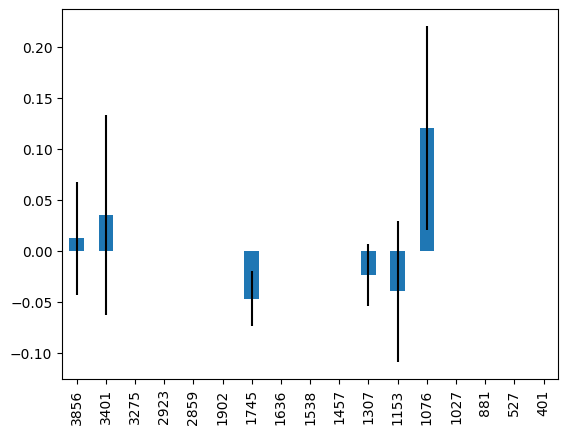

In [ ]:
#|label: barplot
# create a series of the importances mean and add the names of the wavenumber values
forest_importances = pd.Series(r.importances_mean, index=X.columns.values)

# Barplot with sd bars
forest_importances.plot.bar(yerr=r.importances_std)

<Axes: >

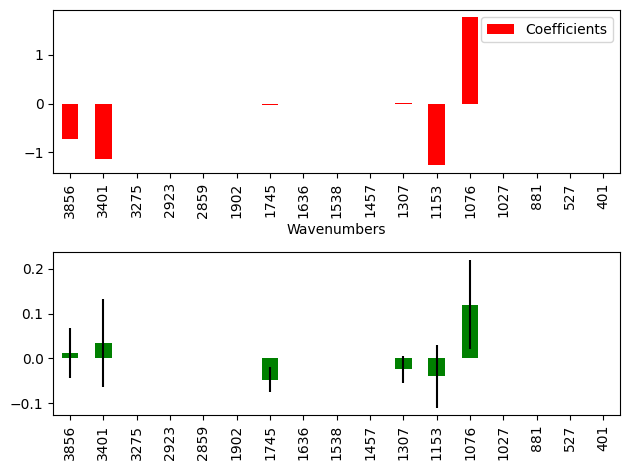

In [ ]:
#|label: comparison
# comparing the two approaches

fig, (ax, ax2) = plt.subplots(2,1, tight_layout=True)

feature_importance.plot.bar(x='Wavenumbers', y='Coefficients', ax=ax, color='r')
forest_importances.plot.bar(yerr=r.importances_std, ax=ax2, color='g')

In [80]:
# using random forest
pipe = Pipeline([('scaler', StandardScaler()), ('model', RandomForestClassifier())])
pipe.fit(X_train, y_train)
print(f"accuracy is: {accuracy_score(y_test, pipe.predict(X_test))})")

accuracy is: 0.9)


In [ ]:
#| label: ftrf
pipe.named_steps['model'].feature_importances_

array([0.17048121, 0.05187198, 0.04152147, 0.06929754, 0.06114025,
       0.06534715, 0.06150834, 0.0610971 , 0.04741274, 0.05061926,
       0.04238396, 0.06812852, 0.04599945, 0.04263272, 0.04370885,
       0.040633  , 0.03621647])

<Axes: xlabel='Wavenumbers'>

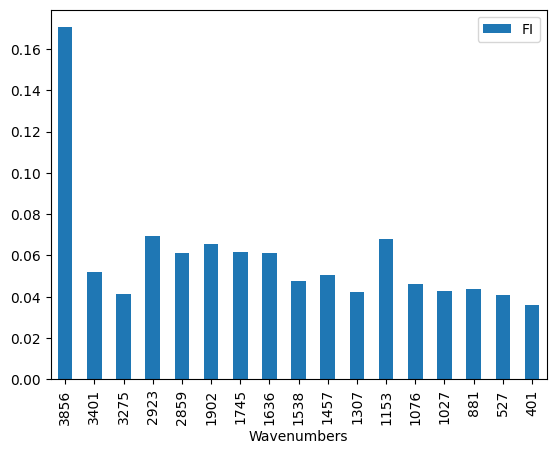

In [ ]:
#|label: RFplot
feature_importance = pd.DataFrame()
feature_importance['Wavenumbers'] = wavenumbers
feature_importance['FI'] = pipe.named_steps['model'].feature_importances_
feature_importance['Wavenumbers'] = feature_importance['Wavenumbers'].astype('category')
feature_importance.plot.bar(x='Wavenumbers', y='FI')

In [83]:
# test set
r = permutation_importance(pipe, X_test, y_test,
                           n_repeats=50,
                           random_state=0, scoring='accuracy')
forest_importances = pd.Series(r.importances_mean, index=X.columns.values)

# train set
r_train = permutation_importance(pipe, 
                                  X_train, 
                                  y_train, 
                                  n_repeats=50, 
                                  random_state=0, 
                                  scoring='accuracy')


Text(0, 0.5, 'Feature importance permutation')

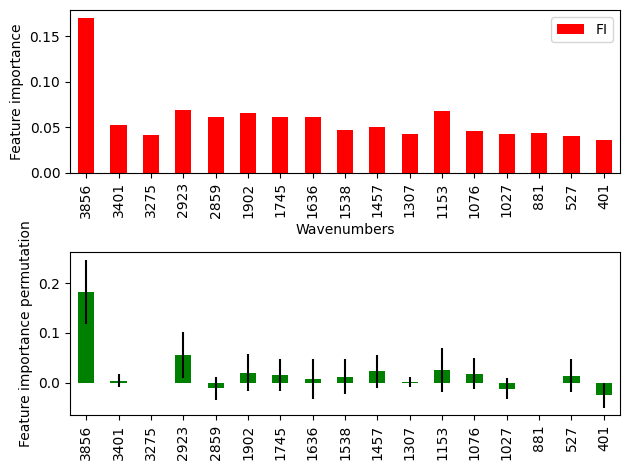

In [ ]:
#|label: rfcomparison
fig, (ax, ax2) = plt.subplots(2,1, tight_layout=True)

feature_importance.plot.bar(x='Wavenumbers', y='FI', ax=ax, color='r')
forest_importances.plot.bar(yerr=r.importances_std, ax=ax2, color='g')
ax.set_ylabel('Feature importance')
ax2.set_ylabel('Feature importance permutation')

In [85]:
# test
sorted_importances_idx = r.importances_mean.argsort()
importances = pd.DataFrame(
    r.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx])

# train
sorted_importances_idx_train = r_train.importances_mean.argsort()
importances_train = pd.DataFrame(
    r_train.importances[sorted_importances_idx_train].T,
    columns=X.columns[sorted_importances_idx_train])


print(importances.head(2))
print(importances_train.head(2))

   401  1027  2859  3275  881  1307  3401  1636  1538   527  1745  1076  1902  \
0  0.0 -0.05  0.00   0.0  0.0   0.0   0.0  0.05  0.10  0.05  0.05  0.00  0.05   
1  0.0  0.00 -0.05   0.0  0.0   0.0   0.0  0.05 -0.05  0.00  0.00  0.05  0.05   

   1457  1153  2923  3856  
0  0.05  0.15  0.05   0.2  
1  0.00  0.00  0.05   0.2  
   1538  881  1027  1076  1307  1457  527  401  1902  2923  3275  3401  1636  \
0   0.0  0.0   0.0   0.0   0.0   0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   
1   0.0  0.0   0.0   0.0   0.0   0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   

   1745  2859  1153  3856  
0   0.0   0.0   0.0  0.10  
1   0.0   0.0   0.0  0.15  


Text(0.5, 1.0, 'Permutation Importances (train set)')

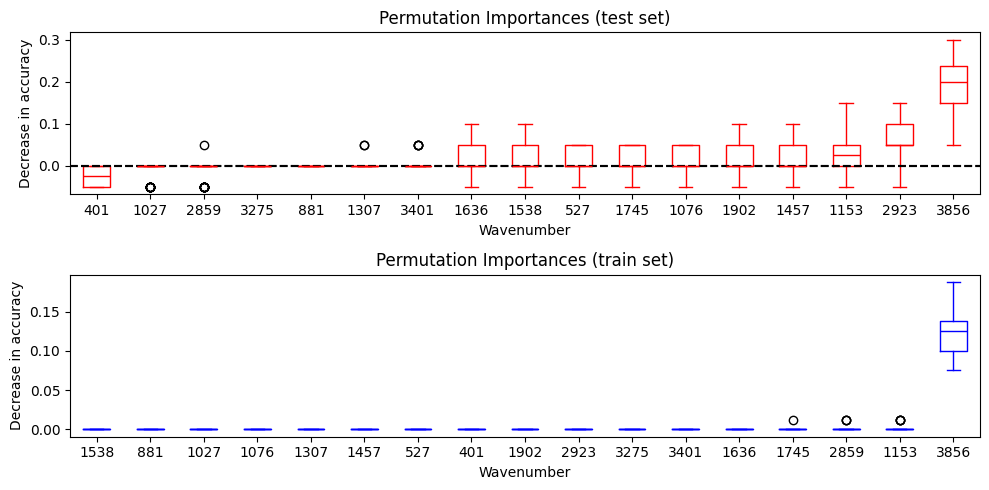

In [ ]:
#|label: finalplot
fig, (ax, ax2) = plt.subplots(2,1,figsize=(10,5), tight_layout=True)
importances.plot.box(vert=True, whis=10, ax=ax, color='r')
ax.axhline(0, ls='--', color='k')

importances_train.plot.box(vert=True, whis=10, ax=ax2, color='b')
ax.axhline(0, ls='--', color='k')


ax.set_xlabel("Wavenumber")
ax.set_ylabel("Decrease in accuracy")
ax.set_title("Permutation Importances (test set)")

ax2.set_xlabel("Wavenumber")
ax2.set_ylabel("Decrease in accuracy")
ax2.set_title("Permutation Importances (train set)")